In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn

from astropy.io import fits
from astropy.visualization import make_lupton_rgb
import random

plt.style.use('dark_background')

In [2]:
class CNN(nn.Module):
    """
    Convolutional Neural Network for multiband data. Note that you
    will need to update the number of in_features for self.fc3.
    """
    def __init__(self, in_channels, num_classes):
        """
		Args:
		    in_channels: number of bands (gri = 3, griz=4)
			num_classes: number of unique labels in your dataset
		"""
        super(CNN, self).__init__()
        
        #Network Components
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=48, 
                               kernel_size=15, 
                               stride=3,
                               padding=2)

        self.conv2 = nn.Conv2d(in_channels=48, 
                               out_channels=96,
                               kernel_size=5, 
                               stride=1,
                               padding=2)
        
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(in_features=3456, 
                             out_features=408)

        self.fc2 = nn.Linear(in_features=408, 
                             out_features=25)

        self.fc3 = nn.Linear(in_features=25, 
                             out_features=num_classes)


    def forward(self, x):
        #Network Flow
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

    def init_weights(self, m):
        if (type(m) == nn.Linear or type(m) == nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [3]:
cnn = CNN(in_channels=3, num_classes=2)

name = '14/model.pt'
name_saved_model = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/models/exp/' + name #'model.pt'
cnn = torch.load(name_saved_model)

In [4]:
weight_tensor = cnn.conv1.weight.data
print(type(weight_tensor))
print(weight_tensor.shape)
first = weight_tensor[0]

<class 'torch.Tensor'>
torch.Size([48, 3, 15, 15])


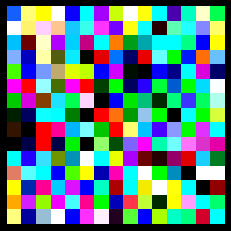

In [5]:
npimg = np.array(first.numpy(), np.float32)
#standardize the numpy image
npimg = (npimg - np.mean(npimg)) / np.std(npimg)
npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
npimg = npimg.transpose((1, 2, 0))

plt.figure()
plt.axis('off')
plt.imshow(npimg)
plt.show()

In [6]:
def plot_weights(weight_tensor, multi):
    plt.figure(figsize=(16,20)) 
    if(multi):
        for i in range(len(weight_tensor)):
            first = weight_tensor[i]
            npimg = np.array(first.numpy(), np.float32)
            #standardize the numpy image
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            npimg = npimg.transpose((1, 2, 0))
            
            plt.subplot(8,6,i+1)
            plt.axis('off')
            plt.imshow(npimg)
        plt.show()
    else:
        for i in range(len(weight_tensor)): 
            plt.subplot(8,6,i+1)
            plt.axis('off')
            plt.imshow(weight_tensor[i], cmap='Greys')
        plt.show()

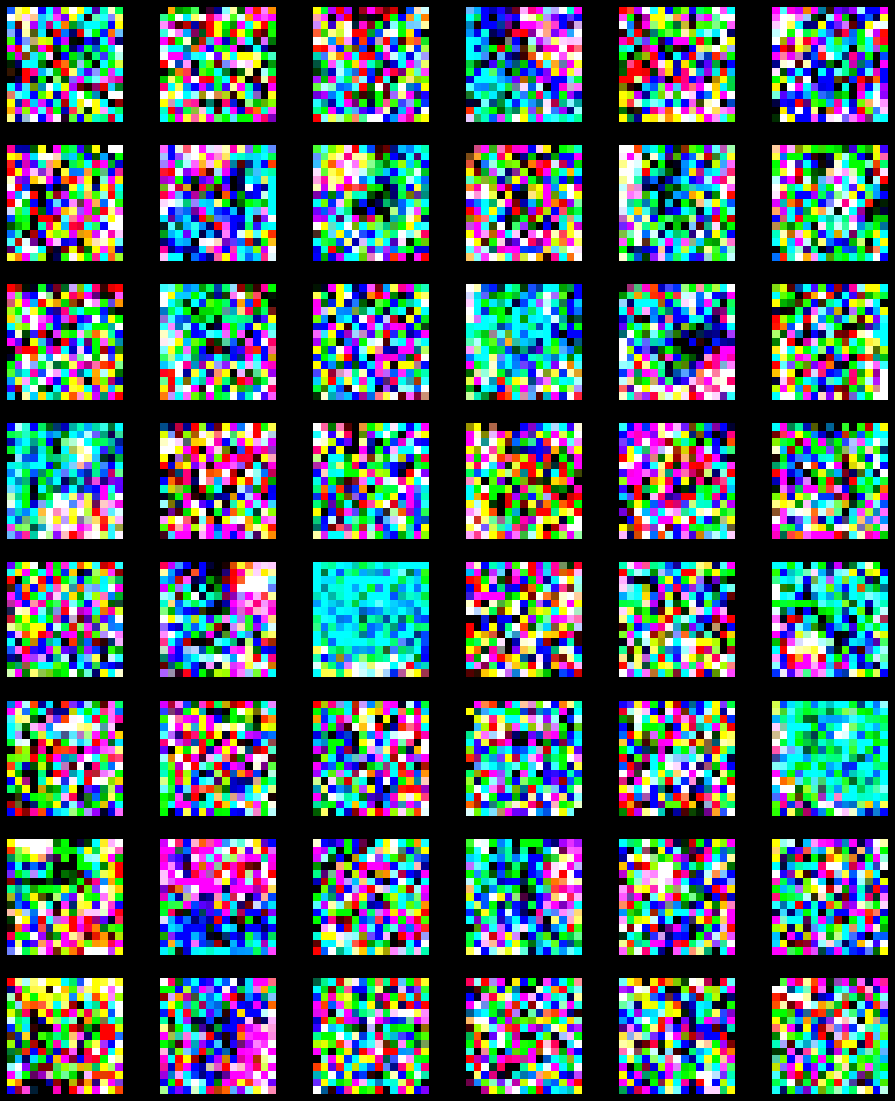

In [7]:
# Layer 1 Filters
weight_tensor = cnn.conv1.weight.data
plot_weights(weight_tensor, multi=True)

In [8]:
weight_tensor = cnn.conv2.weight.data
print(type(weight_tensor))
print(weight_tensor.shape)
weight_tensor = weight_tensor[0]

img = weight_tensor[0]

<class 'torch.Tensor'>
torch.Size([96, 48, 5, 5])


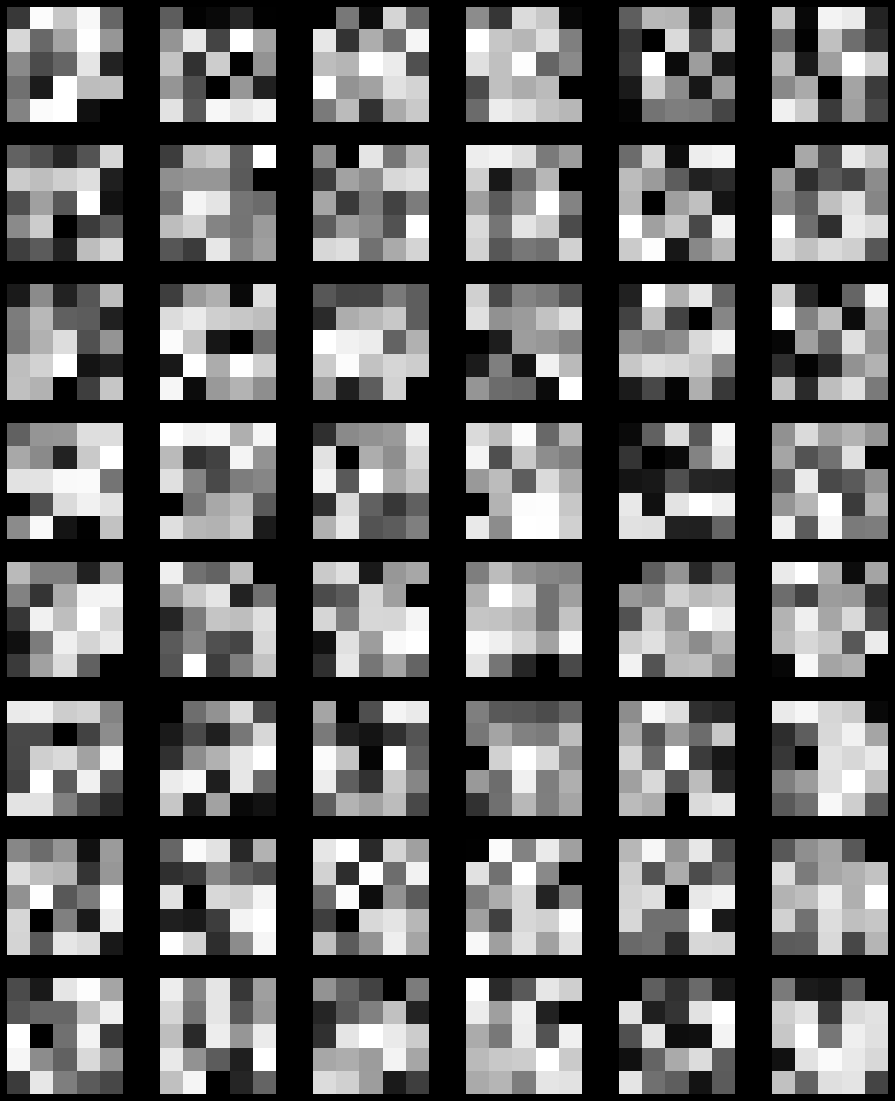

In [9]:
# Some layer 2 filters
weight_tensor = cnn.conv2.weight.data
plot_weights(weight_tensor[3], multi=False)

In [10]:
num_exp = 14
num_sim = 10
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/'

# Positive cases
hdu_list = fits.open(path + 'exp/' + str(num_exp) + '.fits')
idx = random.sample(range(len(hdu_list[1].data)), num_sim)
sim = hdu_list[1].data[idx,:] 
data_sim = hdu_list[2].data[:][idx] #Simulations parameters data
data_sim = data_sim.astype([('z', '>f8'), ('m', '>f8'), ('b', '>f8'), ('E', '>f8')])
hdu_list.close()


In [11]:
print(sim.shape)
images = sim.astype(np.float32)

(10, 3, 46, 46)


In [12]:
first = images[0]

In [13]:
activ = cnn.conv1(torch.from_numpy(images).float())

In [14]:
print(type(activ))
print(activ.shape)

<class 'torch.Tensor'>
torch.Size([10, 48, 12, 12])


In [15]:
first = activ[5]
first.shape

torch.Size([48, 12, 12])

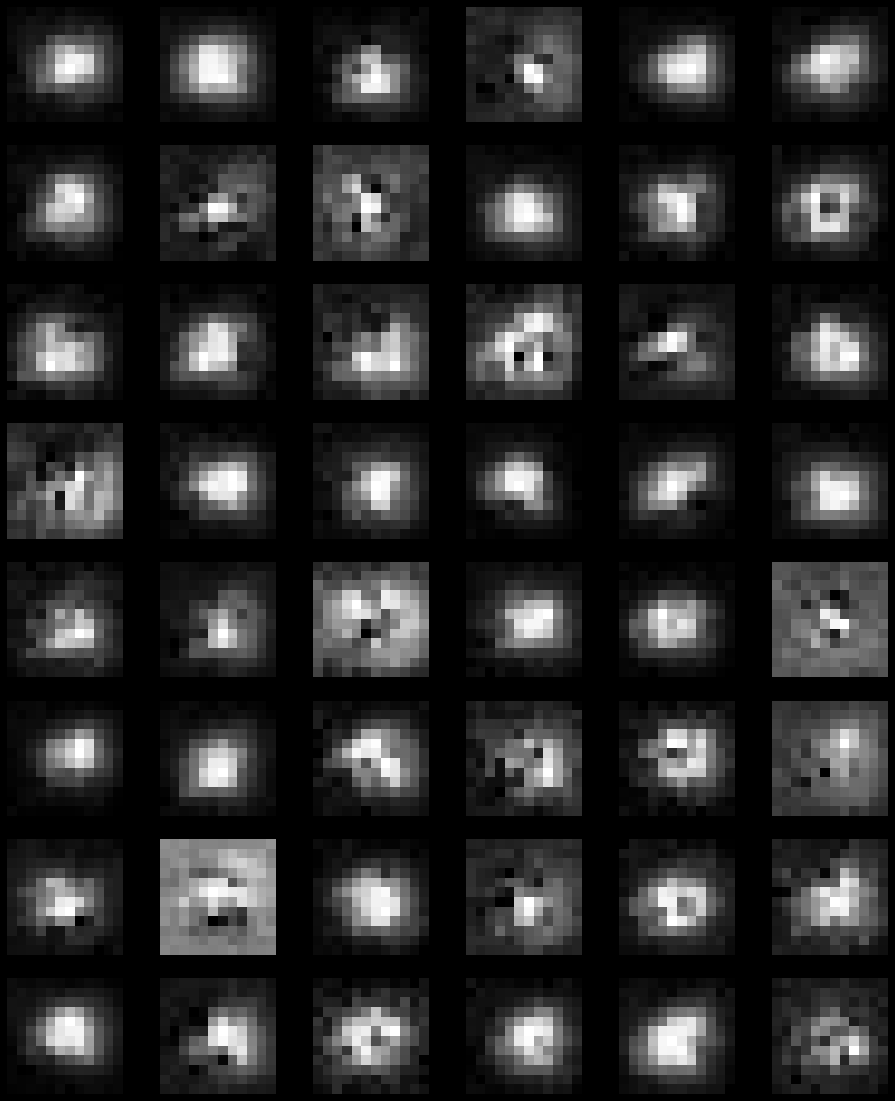

In [16]:
#tensor.detach().numpy()
plot_weights(first.detach().numpy(), multi=False)

In [17]:
activ2 = cnn.conv2(activ.detach().numpy())

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not numpy.ndarray